Importando as bibliotecas que serão utilizadas e carregando os dados

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [ ]:
df = pd.read_parquet('FullDataToDb.parquet')

In [ ]:
df = df.drop(['aircraftSerNum-1','date'], axis="columns")

Seleção das variáveis numéricas para a normalização

In [ ]:
snVars = ['DeltaPressAltitude-1a',
       'DeltaBleedOutTemp-1b','DeltaBleedMonPress-1b', 'MeanBleedOutTemp-1b',
       'MeanBleedMonPress-1b', 'MeanPressAltitude-1a','time_since_maintenance']
nDf = df[snVars]
nDf

,DeltaPressAltitude-1a,DeltaBleedOutTemp-1b,DeltaBleedMonPress-1b,MeanBleedOutTemp-1b,MeanBleedMonPress-1b,MeanPressAltitude-1a,time_since_maintenance
0,27.0,19.250,111.625,204.736609,55.770472,35001.902023,1037950
1,32258.0,46.750,138.500,210.901265,84.130888,14700.678297,2405000
2,32215.0,48.750,124.000,207.049568,100.138864,18408.192598,3544700
3,602.0,23.500,142.375,202.832240,71.176793,34995.797687,4616300
4,32945.0,25.625,142.375,206.352423,74.899656,13905.362082,6418300
...,...,...,...,...,...,...,...
138231,2097.0,14.000,13.750,203.989268,52.391456,39460.626571,2966101200
138232,38122.0,24.250,138.125,206.437927,74.699921,17310.217261,2967588300
138233,36853.0,41.000,123.875,202.096109,82.938608,24549.926673,2969328400
138234,98.0,22.375,133.750,203.914419,53.228401,39005.084119,2970426800


In [ ]:
scaler = StandardScaler()
scaler.fit(nDf)
scaler.fit_transform(nDf)
nDf_norma = scaler.transform(nDf)

In [ ]:
df3 = pd.DataFrame(nDf_norma)

In [ ]:
df2 =['preFail','phaseOfFlight-1']
df4 = df[df2]

In [ ]:
dfN = pd.concat([df4,df3],axis=1)

In [ ]:
dfN = dfN.rename(columns={0:'DeltaPressAltitude-1a',1:'DeltaBleedOutTemp-1b',2:'DeltaBleedMonPress-1b',3:'MeanBleedOutTemp-1b',4:'MeanBleedMonPress-1b',5:'MeanPressAltitude-1a',6:'time_since_maintenance'})

Analizando a correlação novamento após a normalização e com as variáveis não normalizadas (phaseOFlight e preFail)

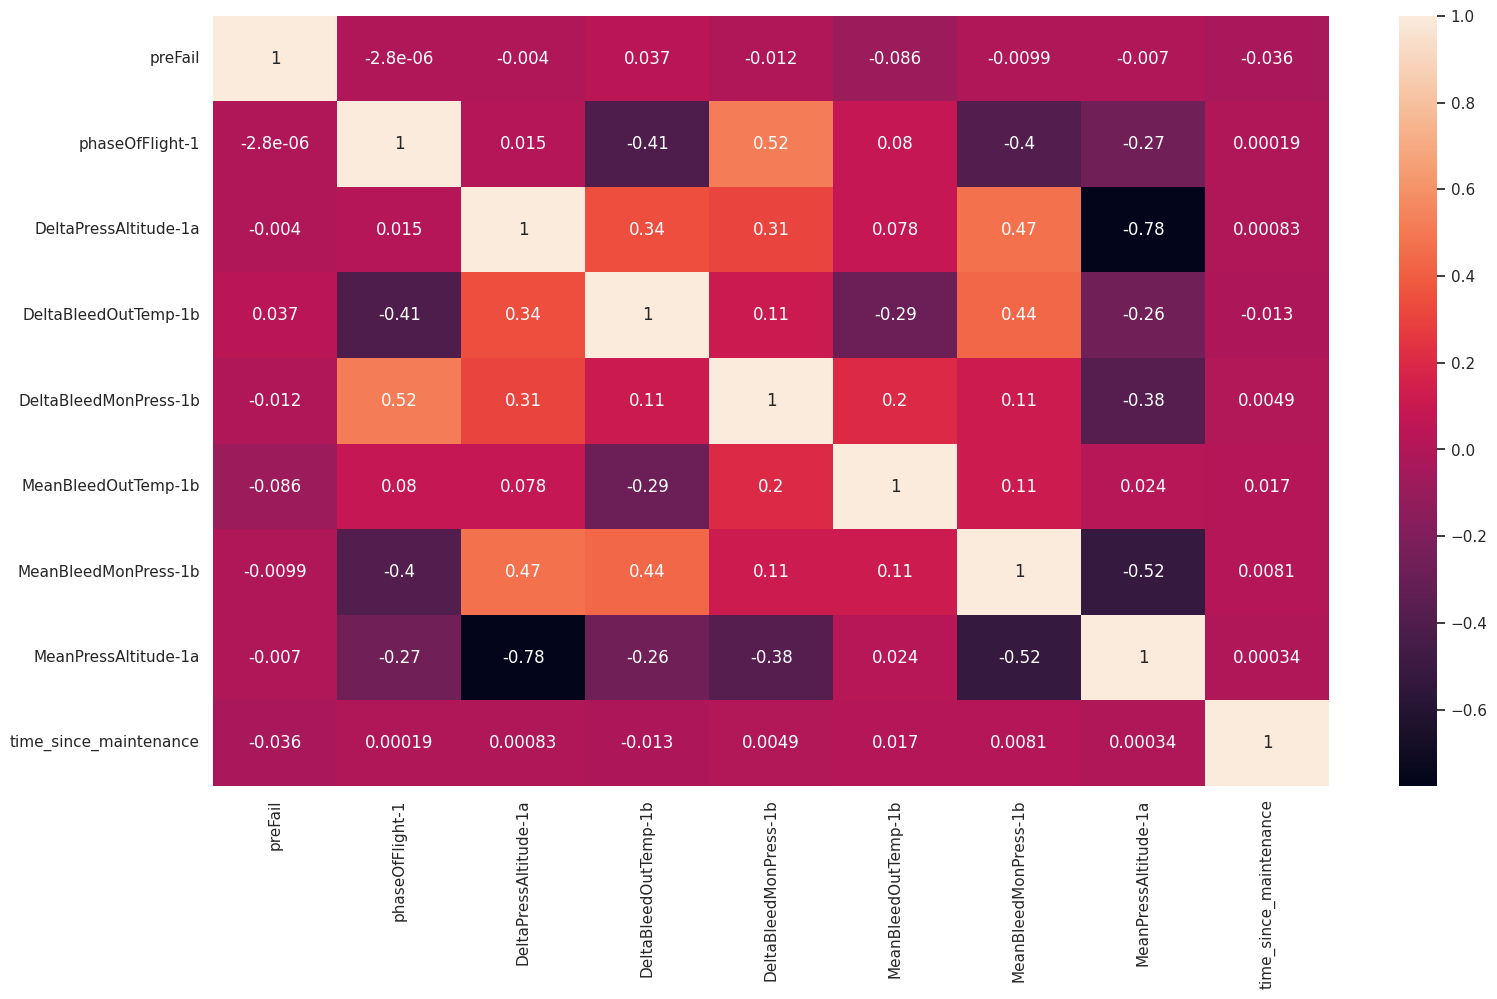

In [ ]:
sns.set(rc = {'figure.figsize':(18,10)})
ax = sns.heatmap(dfN.corr(), annot=True)

In [ ]:
df.columns

Index(['DeltaPressAltitude-1a', 'DeltaPressAltitude-2a',
       'DeltaBleedOutTemp-1b', 'DeltaBleedOutTemp-2b', 'DeltaBleedMonPress-1b',
       'DeltaBleedMonPress-2b', 'MeanBleedOutTemp-1b', 'MeanBleedOutTemp-2b',
       'MeanBleedMonPress-1b', 'MeanBleedMonPress-2b', 'MeanPressAltitude-1a',
       'MeanPressAltitude-2a', 'phaseOfFlight-1', 'Flight',
       'time_since_maintenance', 'preFail'],
      dtype='object')

In [ ]:
dfN.columns

Index(['preFail', 'phaseOfFlight-1', 'DeltaPressAltitude-1a',
       'DeltaBleedOutTemp-1b', 'DeltaBleedMonPress-1b', 'MeanBleedOutTemp-1b',
       'MeanBleedMonPress-1b', 'MeanPressAltitude-1a',
       'time_since_maintenance'],
      dtype='object')

Divisão entre x e y para aplicação do oversampler com BorderLineSMOTE

In [ ]:
df_x = dfN.drop('preFail', axis ='columns')

In [ ]:
df_y = dfN['preFail']

In [ ]:
x = df_x
y = df_y
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x, y)

In [ ]:
dfN_O = pd.concat([X_res,y_res], axis='columns')

Divisão de x e y para treino e validação do modelo e divisão de teste do modelo

In [ ]:
dfNxt = dfN.drop(['preFail'], axis='columns')

In [ ]:
XT = dfNxt
YT = dfN['preFail']
x_train_test, x_test_test, y_train_test, y_test_test = train_test_split(XT,YT,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
dfNx = dfN_O.drop(['preFail'], axis='columns')

separação de um conjunto de teste com oversample


In [ ]:
X = dfNx
Y = dfN_O['preFail']
x_train_rest, x_test, y_train_rest, y_test = train_test_split(X,Y,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
XV = x_train_rest
YV = y_train_rest
x_train, x_val, y_train, y_val = train_test_split(XV,YV,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
clf = ExtraTreesClassifier(n_estimators=400, random_state=42, min_samples_split =2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 50, bootstrap = False)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)

Criação da matriz confusão

In [ ]:
y_true = y_val
cm = confusion_matrix(y_true, y_pred)
cm

array([[26703,   867],
       [  360, 27420]])

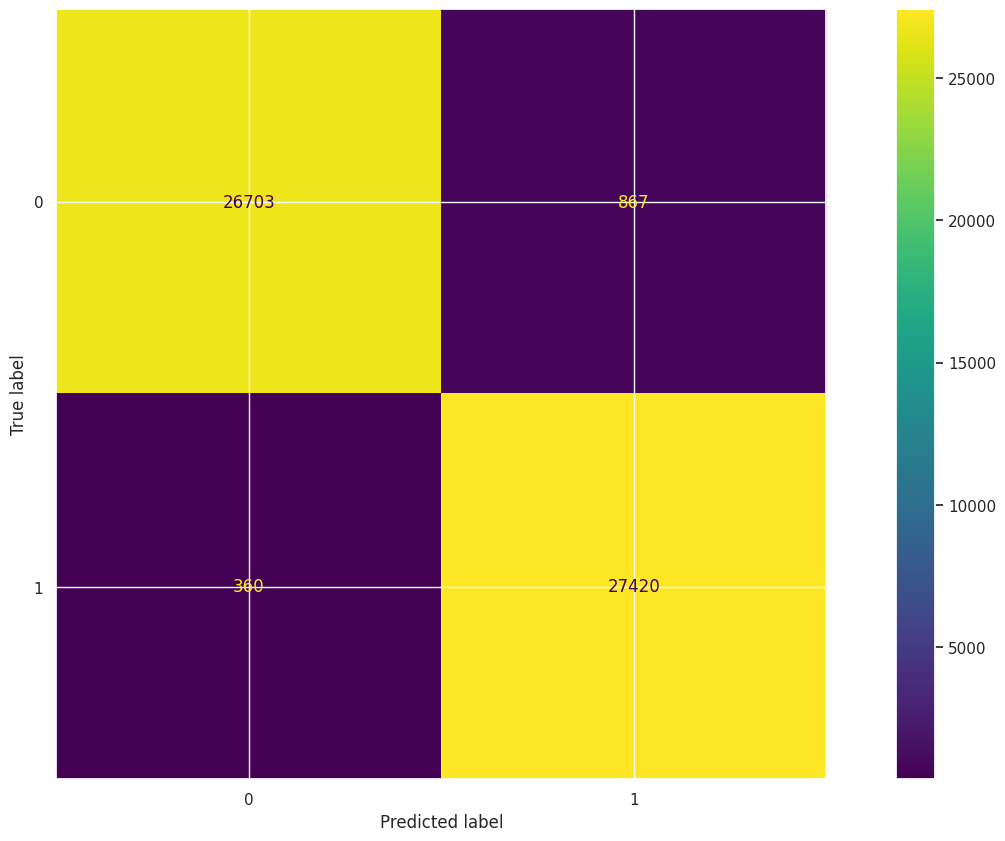

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

Analisando a correlação das variaveis com a feature target ou analisando a feature importance

In [ ]:
matriz_corr = dfN.corr().style.background_gradient(cmap='coolwarm')
target_corr = matriz_corr.data['preFail']
df_corr = target_corr.abs().sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')
df_corr

,preFail
preFail,1.000000
MeanBleedOutTemp-1b,0.086479
DeltaBleedOutTemp-1b,0.036827
time_since_maintenance,0.036385
DeltaBleedMonPress-1b,0.011516
MeanBleedMonPress-1b,0.009873
MeanPressAltitude-1a,0.006972
DeltaPressAltitude-1a,0.003957
phaseOfFlight-1,0.000003


Métricas do modelo

In [ ]:
print("ACCURACY OF THE MODEL: ",accuracy_score(y_val, y_pred))
print("Precision: ", metrics.precision_score(y_val, y_pred))
print("Recall: ", metrics.recall_score(y_val, y_pred))
f1 = f1_score(y_val, y_pred)
print('F1-Score: %f' % f1)

ACCURACY OF THE MODEL:  0.9778319783197832
Precision:  0.9693498780358468
Recall:  0.9870410367170627
F1-Score: 0.978115


In [ ]:
# salvar modelo
import pickle
# salvar o modelo XGBoost (xgb_model) no arquivo sale_xgboost.pkl
with open('modelo.pkl', 'wb') as file:
    pickle.dump(clf, file)

KeyboardInterrupt: ignored

Iniciando o processo de hiper parâmetros

In [ ]:
param_grid = {
   'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
n_estimators=400, random_state=42, min_samples_split =2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 50, bootstrap = False

In [ ]:
{ 'n_estimators': [400],
    'max_depth': [50],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

In [ ]:
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=15, scoring='recall', n_jobs=-1, random_state=42, verbose=2)

In [ ]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

In [ ]:
best_params

In [ ]:
best_estimator

Aplicando validação cruzada

In [ ]:
scores = cross_val_score(clf,X,Y,cv=5)

In [ ]:
scores

Teste com o conjunto desconhecido mas com oversample

In [ ]:
y_pred_Real = clf.predict(x_test)

In [ ]:
y_true_Real = y_test
cm = confusion_matrix(y_true_Real, y_pred_Real)
cm

array([[38242,  1282],
       [  501, 39046]])

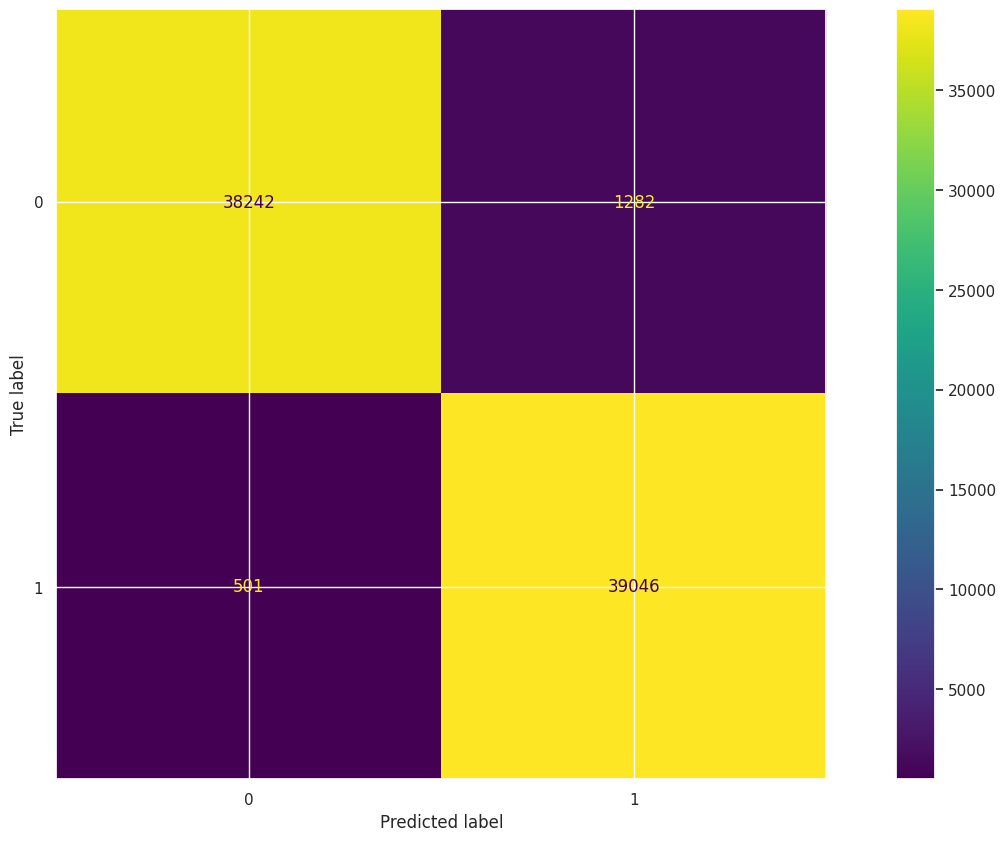

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

In [ ]:
print("ACCURACY OF THE MODEL: ",accuracy_score(y_test, y_pred_Real))
print("Precision: ", metrics.precision_score(y_test, y_pred_Real))
print("Recall: ", metrics.recall_score(y_test, y_pred_Real))
f1 = f1_score(y_test, y_pred_Real)
print('F1-Score: %f' % f1)

ACCURACY OF THE MODEL:  0.9774506456222888
Precision:  0.968210672485618
Recall:  0.9873315295724076
F1-Score: 0.977678


teste com conjunto desconhecido e sem oversample

In [ ]:
y_pred_SO = clf.predict(x_test_test)

In [ ]:
y_true_SO = y_test_test
cm = confusion_matrix(y_true_SO, y_pred_SO)
cm

array([[38754,   769],
       [  136,  1812]])

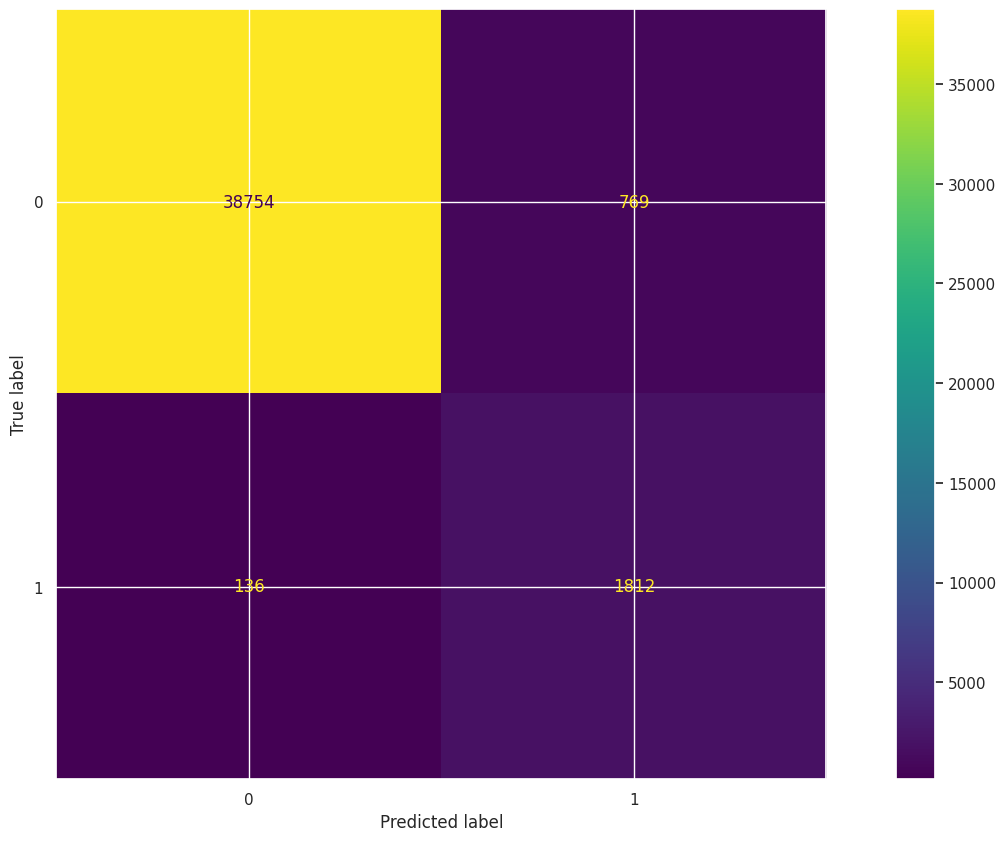

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

In [ ]:
print("ACCURACY OF THE MODEL: ",accuracy_score(y_test_test, y_pred_SO))
print("Precision: ", metrics.precision_score(y_test_test, y_pred_SO))
print("Recall: ", metrics.recall_score(y_test_test, y_pred_SO))
f1 = f1_score(y_test_test, y_pred_SO)
print('F1-Score: %f' % f1)

ACCURACY OF THE MODEL:  0.9781775216416291
Precision:  0.7020534676481984
Recall:  0.9301848049281314
F1-Score: 0.800177
